# Test validity step 1 : $P(\eta | ...) \propto \eta^t \left( C_{approx}^{1/2} (C_{approx}^{-1} + (E^t (B^t N^{-1} B)^{-1} E)^{-1}) C_{approx}^{1/2} \right)^{-1} \eta$

In [50]:
import os, sys
import numpy as np
import matplotlib.pyplot as plt
import healpy as hp
import astropy.io.fits as fits
import scipy
import camb
import jax
import jax.numpy as jnp
import jax.scipy as jsp
import jax_healpy as jhp
import jax.lax as jlx

import micmac as micmac

In [51]:
sys.path.append(os.path.dirname(os.path.abspath('')))
sys.path.append(os.path.dirname(os.path.dirname(os.path.abspath('')))+'/tutorials/')
# from func_tools_for_tests import *
from get_freq_maps_SO_64 import *
# from get_freq_maps_SO_64_lower_noise import *
# from get_freq_maps_LiteBIRD_64 import *
# freq_maps is defined there

In [52]:
instrument

,frequency,depth_p,depth_i,fwhm,f_sky,status,reference,type,note,experiment
0,27.0,4.95,3.50,91.0,0.1,forecast,Journal of Cosmology and Astroparticle Physics...,ground,depth_p is simply depth_i * sqrt(2),SO_SAT
1,39.0,2.97,2.10,63.0,0.1,forecast,Journal of Cosmology and Astroparticle Physics...,ground,depth_p is simply depth_i * sqrt(2),SO_SAT
2,93.0,0.37,0.26,30.0,0.1,forecast,Journal of Cosmology and Astroparticle Physics...,ground,depth_p is simply depth_i * sqrt(2),SO_SAT
3,145.0,0.47,0.33,17.0,0.1,forecast,Journal of Cosmology and Astroparticle Physics...,ground,depth_p is simply depth_i * sqrt(2),SO_SAT
4,225.0,0.89,0.63,11.0,0.1,forecast,Journal of Cosmology and Astroparticle Physics...,ground,depth_p is simply depth_i * sqrt(2),SO_SAT
5,280.0,2.26,1.60,9.0,0.1,forecast,Journal of Cosmology and Astroparticle Physics...,ground,depth_p is simply depth_i * sqrt(2),SO_SAT


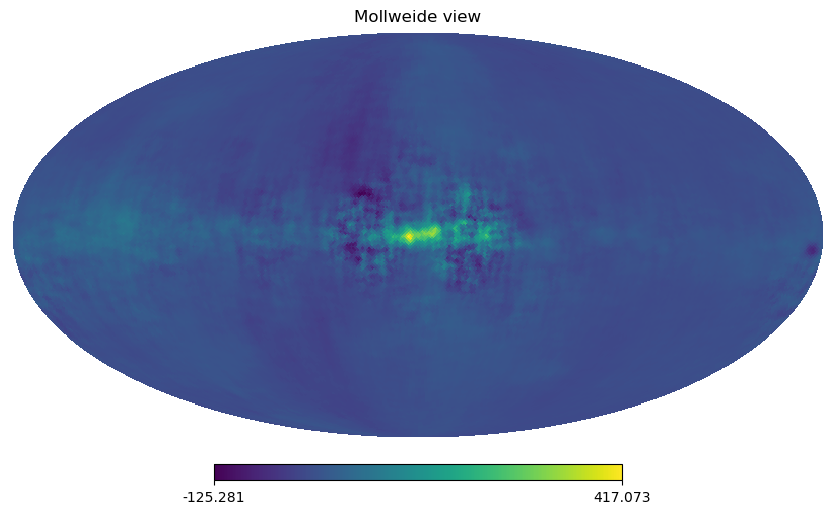

In [53]:
hp.mollview(freq_maps[0,0]) # Freq, nstokes, npix

In [54]:

working_directory_path = '/Users/mag/Documents/PHD1Y/Space_Work/Pixel_non_P2D/MICMAC/test_playground/validation_chain_v2/'
directory_save_file = working_directory_path + 'save_directory/'
directory_toml_file = working_directory_path + 'toml_params/'

path_toml_file = directory_toml_file + 'test_full_chain_v1a.toml'

MAC_obj = micmac.create_MICMAC_sampler_from_toml_file(path_toml_file)

input_freq_maps, _, theoretical_red_cov_r0_total, theoretical_red_cov_r1_tensor = MAC_obj.generate_input_freq_maps_from_fgs(freq_maps_fgs, return_only_freq_maps=False)

# Re-Defining the data if needed
indices_polar = np.array([1,2,4])
partial_indices_polar = indices_polar[:MAC_obj.nstokes]


theoretical_r0_total = micmac.get_c_ells_from_red_covariance_matrix(theoretical_red_cov_r0_total)#[partial_indices_polar,:]
theoretical_r1_tensor = micmac.get_c_ells_from_red_covariance_matrix(theoretical_red_cov_r1_tensor)#[partial_indices_polar,:]


c_ell_approx = np.zeros((3,MAC_obj.lmax+1))
c_ell_approx[0,MAC_obj.lmin:] = theoretical_r0_total[0,:]
c_ell_approx[1,MAC_obj.lmin:] = theoretical_r0_total[1,:]

# Params mixing matrix
init_mixing_matrix_obj = micmac.InitMixingMatrix(MAC_obj.frequency_array, MAC_obj.number_components, pos_special_freqs=MAC_obj.pos_special_freqs)
exact_params_mixing_matrix = init_mixing_matrix_obj.init_params()

mixing_matrix_obj = micmac.MixingMatrix(MAC_obj.frequency_array, MAC_obj.number_components, exact_params_mixing_matrix, pos_special_freqs=MAC_obj.pos_special_freqs)

mixing_matrix_sampled = mixing_matrix_obj.get_B()

BtinvNB = micmac.get_inv_BtinvNB(MAC_obj.freq_inverse_noise, mixing_matrix_sampled)
BtinvN_sqrt = micmac.get_BtinvN(np.sqrt(MAC_obj.freq_inverse_noise), mixing_matrix_sampled)

Calculating spectra from CAMB !
Calculating spectra from CAMB !


In [55]:
red_cov_approx_matrix = micmac.get_reduced_matrix_from_c_ell(c_ell_approx)[MAC_obj.lmin:,...]

In [56]:
# mixing_matrix_init = np.array([[1.,         1.,         0.        ],
#                                 [1.,         0.52387813, 0.00182426],
#                                 [1.,         0.3117258,  0.00324908],
#                                 [1.,         0.21971687, 0.00433627],
#                                 [1.,         0.15096497, 0.0057459 ],
#                                 [1.,         0.10631274, 0.0074421 ],
#                                 [1.,         0.07881344, 0.00935487],
#                                 [1.,         0.05159725, 0.0133358 ],
#                                 [1.,         0.03585547, 0.01906532],
#                                 [1.,         0.02552178, 0.02888587],
#                                 [1.,         0.0193825,  0.04508262],
#                                 [1.,         0.01493871, 0.08217483],
#                                 [1.,         0.01211497, 0.16061503],
#                                 [1.,         0.00871575, 0.37616284],
#                                 [1.,         0.,         1.        ]])

In [57]:
red_cov_approx_matrix.shape

(127, 2, 2)

In [58]:
lmax = MAC_obj.lmax
n_iter = MAC_obj.n_iter
lmin = MAC_obj.lmin
nstokes = MAC_obj.nstokes

In [59]:
%%time

# eta_maps = np.zeros((number_frequencies, nstokes, npix))
# eta_maps = np.zeros((nstokes, npix))
# map_random_x = []
# map_random_y = []
# eta_maps = micmac.get_sampling_eta(param_dict, red_cov_approx_matrix, BtinvNB, BtinvN_sqrt, map_random_x=map_random_x, map_random_y=map_random_y, initial_guess=np.copy(eta_maps), lmin=lmin, n_iter=n_iter, limit_iter_cg=limit_iter_cg, tolerance=tolerance_CG)
# eta_maps = micmac.get_sampling_eta_v2(param_dict, red_cov_approx_matrix, BtinvNB, BtinvN_sqrt, map_random_x=map_random_x, map_random_y=map_random_y, lmin=lmin, n_iter=n_iter)

jax_key_PNRG = jax.random.PRNGKey(MAC_obj.seed+10)
map_random_x = jnp.empty(0)
map_random_y = jnp.empty(0)
eta_maps = MAC_obj.get_sampling_eta_v2(red_cov_approx_matrix, BtinvNB, BtinvN_sqrt, jax_key_PNRG, map_random_x=map_random_x, map_random_y=map_random_y, suppress_low_modes=True)


Recalculating x !
Recalculating y !
CPU times: user 4.66 s, sys: 1.18 s, total: 5.84 s
Wall time: 1.34 s


In [60]:
jitted_sampling_eta = jax.jit(MAC_obj.get_sampling_eta_v2, static_argnames=['suppress_low_modes'])

In [61]:
%%time
eta_maps = jitted_sampling_eta(red_cov_approx_matrix, BtinvNB, BtinvN_sqrt, jax_key_PNRG, map_random_x=map_random_x, map_random_y=map_random_y, suppress_low_modes=True)


Recalculating x !
Recalculating y !
CPU times: user 25.3 s, sys: 566 ms, total: 25.9 s
Wall time: 24.8 s


In [62]:
%%time
eta_maps = jitted_sampling_eta(red_cov_approx_matrix, BtinvNB, BtinvN_sqrt, jax_key_PNRG, map_random_x=map_random_x, map_random_y=map_random_y, suppress_low_modes=True)


CPU times: user 529 ms, sys: 76.8 ms, total: 606 ms
Wall time: 282 ms


In [63]:
%%time
eta_maps = jitted_sampling_eta(red_cov_approx_matrix, BtinvNB, BtinvN_sqrt, jax_key_PNRG, map_random_x=map_random_x, map_random_y=map_random_y, suppress_low_modes=True)


CPU times: user 542 ms, sys: 77 ms, total: 619 ms
Wall time: 129 ms


In [64]:
%%time
eta_maps = jitted_sampling_eta(red_cov_approx_matrix, BtinvNB, BtinvN_sqrt, jax_key_PNRG, map_random_x=map_random_x, map_random_y=map_random_y, suppress_low_modes=True)


CPU times: user 541 ms, sys: 72.8 ms, total: 614 ms
Wall time: 149 ms


In [65]:
eta_maps_extended = np.vstack([np.zeros_like(eta_maps[0]), eta_maps])
c_ells_eta = hp.anafast(eta_maps_extended, lmax=lmax, iter=n_iter)[indices_polar,lmin:]

In [66]:
covariance_noise = np.zeros_like(c_ell_approx)
# covariance_noise[:nstokes,lmin:] = scipy.linalg.sqrtm(BtinvNB)[0,0]*np.ones_like(c_ell_approx)[:nstokes,lmin:]
covariance_noise[:nstokes,lmin:] = BtinvNB[0,0]*np.ones_like(c_ell_approx)[:nstokes,lmin:]
analytical_eta_term = (c_ell_approx + covariance_noise)/np.sqrt(BtinvNB[0,0])

red_cov_approx_matrix_msqrt = np.linalg.pinv(micmac.get_sqrt_reduced_matrix_from_matrix(red_cov_approx_matrix))
red_cov_approx_matrix_sqrt = micmac.get_sqrt_reduced_matrix_from_matrix(red_cov_approx_matrix)

analytical_eta_term_cov = np.einsum('lij,ljk,lkm->lim', red_cov_approx_matrix_sqrt, np.linalg.pinv(red_cov_approx_matrix) + np.eye(nstokes)/BtinvNB[0,0], red_cov_approx_matrix_sqrt)
analytical_eta_term_2 = np.zeros_like(c_ell_approx)
analytical_eta_term_2[:,lmin:] = micmac.get_c_ells_from_red_covariance_matrix(analytical_eta_term_cov)


ell_arange = np.arange(c_ell_approx.shape[1]) + lmin

In [67]:
number_correl_to_plot = int(np.ceil(nstokes**2/2) + np.floor(nstokes/2))

if nstokes == 3:
    number_subplots_convention = 421
    figsize = (10,10)
    figsize_big = (12,12)
    position_legend = int(number_correl_to_plot/2)-1
    bbox_to_anchor=(2.2, 1)
elif nstokes == 2:
    number_subplots_convention = 131
    figsize = (14,6)
    figsize_big = figsize
    position_legend = number_correl_to_plot-1
    bbox_to_anchor=(1, 1)
else:
    number_subplots_convention = 111
    figsize = (10,10)
    figsize_big = (10,10)
    position_legend = int(number_correl_to_plot/2)-1
    bbox_to_anchor=(2.2, 1)

/Users/mag/miniconda3/envs/non_param_silver/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: All values for SymLogScale are below linthresh, making it effectively linear. You likely should lower the value of linthresh. 
  fig.canvas.print_figure(bytes_io, **kw)


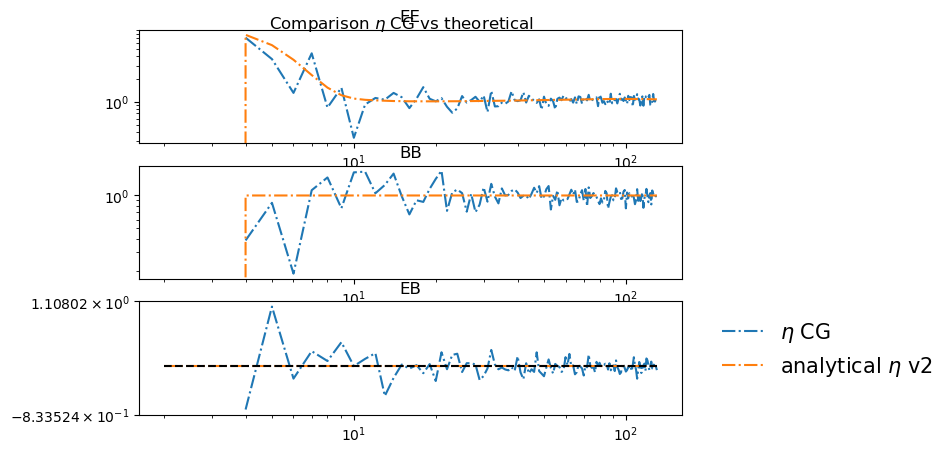

In [68]:
# list_correl = ['TT', 'EE', 'BB', 'TE', 'EB', 'TB']
list_correl = ['EE', 'BB', 'EB']


plt.figure(figsize=(7,5))
plt.suptitle(r"Comparison $\eta$ CG vs theoretical", y=0.91)

for j in range(number_correl_to_plot):
    ax = plt.subplot(311+j)
    plt.title(list_correl[j])

    # plt.plot(ell_arange, c_ell_approx.T[:,j], label='c_ell_approx')
    plt.plot(ell_arange[lmin:], c_ells_eta[j,:], '-.', label=r"$\eta$ CG")
    
    # plt.plot(ell_arange, analytical_eta_term[j,:], '-.', label=r"analytical $\eta$")
    plt.plot(ell_arange, analytical_eta_term_2[j,:], '-.', label=r"analytical $\eta$ v2")
    
    # if j < nstokes:
    #     plt.plot([ell_arange[0], ell_arange[-1]], [1,1], '--', color='black')
    # plt.plot([ell_arange[0], ell_arange[-1]], [0,0], '--', color='black')
    if nstokes == 3 and j < number_correl_to_plot-2:
        plt.xticks(color='w')

    if j <= nstokes-1:
        plt.loglog()
        # plt.ylim(ymin=noise_level/10.)
    else:
        plt.xscale('log')
        plt.yscale('symlog')
    # plt.legend()
    if j == position_legend:
        plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left", prop={'size': 15}, frameon=False)
        plt.plot([ell_arange[0], ell_arange[-1]], [0,0], '--', color='black')


plt.show()

In [69]:
# red_cov_approx_matrix_sqrt = get_sqrt_reduced_matrix_from_matrix_jax(red_cov_approx_matrix)